In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

# Set random seed for reproducibility
np.random.seed(42)

# Comparison of Neural Network versus Linear Regression
I have a dataset with 100 points that are somewhat linear. WE'll use both a linear regression and a neural network to fit the data and see how they compare.

## Generate synthetic data

In [2]:
x = np.linspace(0, 10, 100)
y =  - 2.5 * x + 3 + np.random.normal(1,2,size=x.shape)

## Now fit a linear regression model

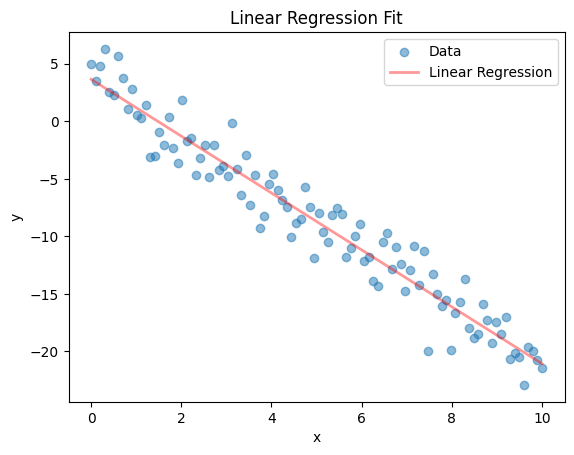

In [3]:
#linear model
x_reshaped = x.reshape(-1, 1)
lin_reg = LinearRegression()
lin_reg.fit(x_reshaped, y)
y_pred_lin = lin_reg.predict(x_reshaped)
#or using np.polyfit
coeffs = np.polyfit(x, y, 1)
y_pred_lin = coeffs[0] * x + coeffs[1]

#plot linear regression results
plt.scatter(x, y, label='Data', alpha=0.5)
plt.plot(x, y_pred_lin, color='red', label='Linear Regression', linewidth=2, alpha = 0.4)
plt.xlabel('x'); plt.ylabel('y')
plt.title('Linear Regression Fit')
plt.legend(); plt.show()

## Now complete regression using a neural network with stochastic gradient descent

In [4]:
# Define layer sizes
n_x = 1  # Number of input features
n_h = 20  # Number of parameters in hidden layer
n_y = 1 # Output size

# --- Initialize Parameters ---
# Input layer 
W1 = np.random.randn(n_h, n_x) * 0.1
b1 = np.zeros((n_h, 1))

# Hidden to output layer
W2 = np.random.randn(n_y, n_h) * 0.1
b2 = np.zeros((n_y, 1))

parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

print(f"Total Parameters: {W1.size + b1.size + W2.size + b2.size}")

Total Parameters: 61


In [5]:
def forward_propagation(xval, parameters):
    xNN = np.array(xval).reshape(-1,1)
    W1 = parameters['W1']; b1 = parameters['b1']
    W2 = parameters['W2']; b2 = parameters['b2']
    
    Z1 = np.dot(W1, xNN) + b1
    A1 = np.maximum(0, Z1)  # ReLU activation
    Z2 = np.dot(W2, A1) + b2
    
    return (Z2, A1, Z1)

In [6]:
def backpropagation(x, y, parameters):
    xNN = x.reshape(-1,1)
    yNN = y.reshape(-1,1)
    
    W2 = parameters['W2']
    
    # Forward pass
    Z2, A1, Z1 = forward_propagation(x,parameters)
    
    # Backward pass
    dZ2 = Z2 - yNN
    dW2 = np.dot(dZ2, A1.T); db2 = np.sum(dZ2, axis=1, keepdims=True)
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * (Z1 > 0)  # Derivative of ReLU
    dW1 = np.dot(dZ1, xNN.T); db1 = np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    
    return grads

In [7]:
def update_parameters(parameters, grads, learning_rate=0.01):
    W1 = parameters['W1']; b1 = parameters['b1']
    W2 = parameters['W2']; b2 = parameters['b2']
    
    dW1 = grads['dW1']; db1 = grads['db1']
    dW2 = grads['dW2']; db2 = grads['db2']
    
    W1 -= learning_rate * dW1; b1 -= learning_rate * db1
    W2 -= learning_rate * dW2; b2 -= learning_rate * db2

    #include random noise to escape local minima
    W1 += np.random.randn(*W1.shape) * 0.003
    W2 += np.random.randn(*W2.shape) * 0.003  
    
    updated_parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    
    return updated_parameters

In [8]:
forward_propagation(x[4], parameters)[0].flatten()[0]

0.002091592695928158

In [9]:
#complete training loop
num_iterations = 2000
learning_rate = 0.004
yhat = np.zeros_like(y)
for i in range(num_iterations+1):
    #update parameters with backpropagation
    for idx in range(len(x)):
        grads = backpropagation(np.array([x[idx]]), np.array([y[idx]]), parameters)
        parameters = update_parameters(parameters, grads, learning_rate)
    
    #print loss every 100 iterations
    if i % 500 == 0:
        #make predictions for each point x and update yhat array
        for idx in range(len(x)):
            yhat[idx] = forward_propagation(x[idx], parameters)[0].flatten()[0]
        #calculate loss
        loss = np.mean((yhat - y) ** 2)
        print(f"Iteration {i}, Loss: {loss}")

Iteration 0, Loss: 11.542996116320248
Iteration 500, Loss: 3.28875962685578
Iteration 1000, Loss: 3.212748868919856
Iteration 1500, Loss: 3.1645402296356746
Iteration 2000, Loss: 3.22945279402176


In [10]:
#compare loss to linear regression
loss, np.mean((y_pred_lin - y) ** 2)

(3.22945279402176, 3.259618853992314)

In [11]:
xar = np.linspace(0, 10, 1000)
yhat2 = np.zeros_like(xar)
for idx in range(len(xar)):
    yhat2[idx] = forward_propagation(xar[idx], parameters)[0].flatten()[0]

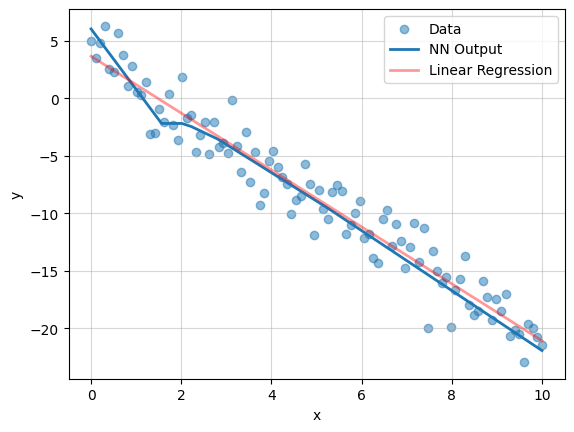

In [12]:
#plot NN output
plt.scatter(x, y, label='Data', alpha=0.5)
plt.plot(xar, yhat2, label='NN Output', linewidth=2)
plt.plot(x, y_pred_lin, color='red', label='Linear Regression', linewidth=2, alpha = 0.4)
plt.xlabel('x'); plt.ylabel('y')
plt.legend();plt.grid(alpha=0.5); 
#plt.savefig('NN_vs_Linear_Regression.png', dpi=300); 
plt.show()

In [13]:
#make predictions with trained NN for single value
x_new = 0.01
y_new_pred = forward_propagation(x_new, parameters)[0].flatten()[0]
print(f"Prediction for x={x_new}: y={y_new_pred}")

Prediction for x=0.01: y=5.9738142216297625


## With Batch Gradient Descent

In [14]:
# --- 1. Data Setup (Vectorized X and Y) ---
# X: Input (n_x, m) -> (2, 10)
X = x.reshape(1, -1)
# Y: True output (n_y, m) -> (1, 10)
Y_raw = y
Y = Y_raw.reshape(1, -1) 
m = X.shape[1] # Number of examples (m=10)

# --- 2. Network Constants & Initialization ---
n_x = X.shape[0] # 2
n_h = 30 
n_y = Y.shape[0] # 1

W1 = np.random.randn(n_h, n_x) * 0.1
b1 = np.zeros((n_h, 1)) # Still (n_h, 1) due to broadcasting
W2 = np.random.randn(n_y, n_h) * 0.1
b2 = np.zeros((n_y, 1)) # Still (n_y, 1) due to broadcasting
parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

# --- 3. Helper Functions (Vectorized) ---

def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    dZ = np.array(Z, copy=True)
    dZ[Z <= 0] = 0
    dZ[Z > 0] = 1
    return dZ

def forward_propagation_vec(X, parameters):
    """
    Vectorized Forward Pass. X is (n_x, m).
    """
    W1, b1, W2, b2 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"]
    
    # Layer 1: Z1 is (n_h, m)
    Z1 = np.dot(W1, X) + b1 
    A1 = relu(Z1)
    
    # Layer 2: Z2 is (n_y, m)
    Z2 = np.dot(W2, A1) + b2 
    A2 = Z2 # Linear output for regression
    
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache # A2 is the predicted Y_hat (1, m)

def backward_propagation_vec(X, Y, cache, parameters):
    """
    Vectorized Backward Pass. X and Y are (n, m).
    """
    m = X.shape[1]
    W2 = parameters["W2"]
    A1, Z1, A2 = cache["A1"], cache["Z1"], cache["A2"]
    
    # --- Output Layer (Layer 2) Gradients ---
    dZ2 = A2 - Y  # Error term (1, m)
    dW2 = np.dot(dZ2, A1.T) / m # (1, n_h)
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m # (1, 1)
    
    # --- Hidden Layer (Layer 1) Gradients ---
    dA1 = np.dot(W2.T, dZ2) # (n_h, m)
    dZ1 = dA1 * relu_derivative(Z1) # (n_h, m) - Element-wise product
    dW1 = np.dot(dZ1, X.T) / m # (n_h, n_x)
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m # (n_h, 1)
    
    return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

def update_parameters(parameters, grads, learning_rate):
    """Updates parameters using the gradient descent rule."""
    parameters["W1"] -= learning_rate * grads["dW1"]
    parameters["b1"] -= learning_rate * grads["db1"]
    parameters["W2"] -= learning_rate * grads["dW2"]
    parameters["b2"] -= learning_rate * grads["db2"]
    return parameters

In [15]:
# Hyper-parameters
NUM_ITERATIONS = 2000
LEARNING_RATE = 0.004

print(f"Starting Vectorized Training (m={m} examples)")

for i in range(NUM_ITERATIONS + 1):
    
    # 1. Forward Propagation (over ALL m examples)
    Y_hat, cache = forward_propagation_vec(X, parameters)
    
    # 2. Calculate Cost (MSE over ALL m examples)
    # Loss = (1/m) * SUM((Y_hat - Y)^2)
    cost = np.mean(np.square(Y_hat - Y))
    
    # 3. Backpropagation (over ALL m examples)
    grads = backward_propagation_vec(X, Y, cache, parameters)
    
    # 4. Parameter Update
    parameters = update_parameters(parameters, grads, LEARNING_RATE)
    
    # Print loss every 500 iterations
    if i % 500 == 0:
        print(f"Iteration {i}, Loss: {cost:.6f}")

# --- 5. Final Evaluation ---
print("\n--- Final Vectorized Evaluation ---")
Y_final_pred, _ = forward_propagation_vec(X, parameters)

final_loss = np.mean(np.square(Y_final_pred - Y))
print(f"Final MSE Loss: {final_loss:.6f}")

print("\nSample True Values vs. Predictions (Vectorized):")
comparison_table = np.stack((Y.flatten(), Y_final_pred.flatten()), axis=1)

print("True Y | Predicted Y")
print("-------------------")
for true_val, pred_val in comparison_table[:5]: # Show first 5 examples
    print(f"{true_val:.4f} | {pred_val:.4f}")

Starting Vectorized Training (m=100 examples)
Iteration 0, Loss: 133.390838
Iteration 500, Loss: 3.921131
Iteration 1000, Loss: 3.656961
Iteration 1500, Loss: 3.532537
Iteration 2000, Loss: 3.459219

--- Final Vectorized Evaluation ---
Final MSE Loss: 3.459123

Sample True Values vs. Predictions (Vectorized):
True Y | Predicted Y
-------------------
4.9934 | 2.0040
3.4709 | 2.0040
4.7903 | 2.0040
6.2885 | 2.0040
2.5216 | 2.0040


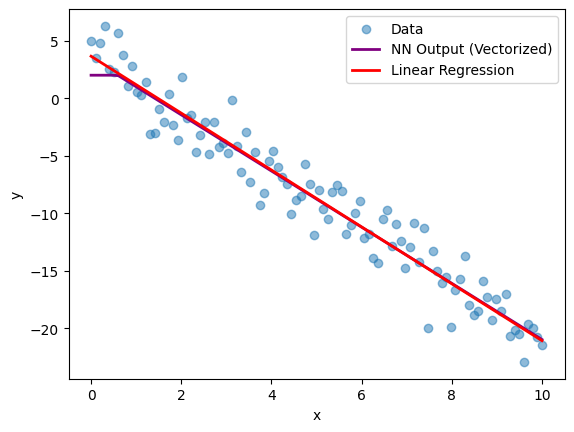

In [16]:
#plot NN output
plt.scatter(x, y, label='Data', alpha=0.5)
plt.plot(x, Y_final_pred.flatten(), color='purple', label='NN Output (Vectorized)', linewidth=2)
plt.plot(x, y_pred_lin, color='red', label='Linear Regression', linewidth=2)
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.show()